In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import datetime
from PIL import Image
from keras.datasets import cifar10
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
                                    Add, AveragePooling2D, Flatten, Dense, Dropout, Activation,MaxPooling2D
import tensorflow.keras.layers as layers
from keras.models import Sequential
import tensorflow.keras.optimizers
import seaborn as sns
from sklearn.utils import class_weight
import keras as k
from keras import regularizers
from keras.callbacks import LearningRateScheduler

# بخش ۱

One of the reasons why overfitting might occur is the lack of data. Indeed, if you are training your model on too few data, it will try to exasperate its extraction of features from the training data, with the risk of identifying patterns that do not exist.
However, it often happens that available data are very few and that is all we can have. Namely, imagine a manufacturing company that wants to examine snapshots of its machinery with the goal of classifying them as “healthy” or “at risk of breakdown”. To train its algorithm (let’s say, a convolutional neural network, CNN) the company will need a bunch of pre-labeled images. The procedure of data collection will need time, but what if the company wants to accelerate the process, starting from a small sample of images? Well, rather than waiting for new images to come, the company could use the available data and derive new images from them, in such a way that each “new image” is created consistently with respect to the existing ones.
This process is called data augmentation and it is extremely powerful in terms of the increase of accuracy of the model

There is a variety of ways in which images can be created starting from those available. Let’s examine the most popular and intuitive ones

* Shifting the images horizontally or vertically. 

With this technique, we can specify the percentage of pixels (or their number) to be shifted up/down or left/right. By doing so, there will be some pixels that will be disappearing from the image, while some others will need to be imputed . Note that the shift parameter will need a range of values (as mentioned above, either a percentage or a number), from which it will randomly pick.


* Flipping the images.

Again, we can flip it horizontally or vertically, This scenario is more important for network to remove biasness of assuming certain features of the object is available in only a particular side. Consider the case shown in image example. You don’t want network to learn that tilt of banana happens only in right side as observed in the base image. Also notice that flipping produces different set of images from rotation at multiple of 90 degrees.

* Scaling:

Having differently scaled object of interest in the images is the most important aspect of image diversity. When your network is in hands of real users, the object in the image can be tiny or large. Also, sometimes, object can cover the entire image and yet will not be present totally in image (i.e cropped at edges of object)

* Translation:


We would like our network to recognize the object present in any part of the image. Also, the object can be present partially in the corner or edges of the image. For this reason, we shift the object to various parts of the image. This may also result in addition of a background noise. 

* Rotation (at 90 degrees):

The network has to recognize the object present in any orientation. Assuming the image is square, rotating the image at 90 degrees will not add any background noise in the image.

* Rotation (at finer angles):

Depending upon the requirement, there maybe a necessity to orient the object at minute angles. However problem with this approach is, it will add background noise. If the background in image is of a fixed color (say white or black), the newly added background can blend with the image. However, if the newly added background color doesn’t blend, the network may consider it as to be a feature and learn unnecessary features.


* Adding Salt and Pepper noise:


Salt and Pepper noise refers to addition of white and black dots in the image. Though this may seem unnecessary, it is important to remember that a general user who is taking image to feed into your network may not be a professional photographer. His camera can produce blurry images with lots of white and black dots

* Lighting condition:

This is a very important type of diversity needed in the image dataset not only for the network to learn properly the object of interest but also to simulate the practical scenario of images being taken by the user. The lighting condition of the images are varied by adding Gaussian noise in the image.

* Perspective transform:

In perspective transform, we try to project image from a different point of view. For this, the position of object should be known in advance. Merely calculating perspective transform without knowing the position of the object can lead to degradation of the dataset. Hence, this type of augmentation has to be performed selectively. The greatest advantage with this augmentation is that it can emphasize on parts of object in image which the network needs to learn.



You train your model on the training data and the validation data: the former to optimize your parameters, and the latter to give you an appropriate stopping condition. The test data is to give you a real-world estimate of how well you can expect your model to perform.

For training, you can augment your training data to increase robustness to various factors including, but not limited to, sampling error, bias between data sources, shifts in global data distribution, positioning, and any other sort of variation you would like to account for.

The validation data should indicate to the training method when the model is most generalizable. By this logic, if you expect to see some variation in real-world data that can be simulated using data augmentation, then by all means, the validation dataset should be augmented.

The test data, on the other hand, should not be augmented, except potentially in special scenarios where data is very limited, and an estimate of real-world performance on test data has too much variance.

# بخش ۲

## Main image

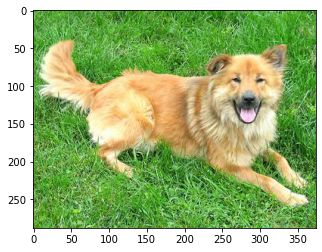

In [ ]:
image = load_img('./4.jpg')
img = img_to_array(image)
img = img/255
img = img.reshape((1,) + img.shape)
plt.imshow(img[0])

In [ ]:
## setting generator
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

## Showing augmentaitons


(288, 374, 3)
(288, 374, 3)
(288, 374, 3)
(288, 374, 3)
(288, 374, 3)
(288, 374, 3)
(288, 374, 3)
(288, 374, 3)
(288, 374, 3)
(288, 374, 3)


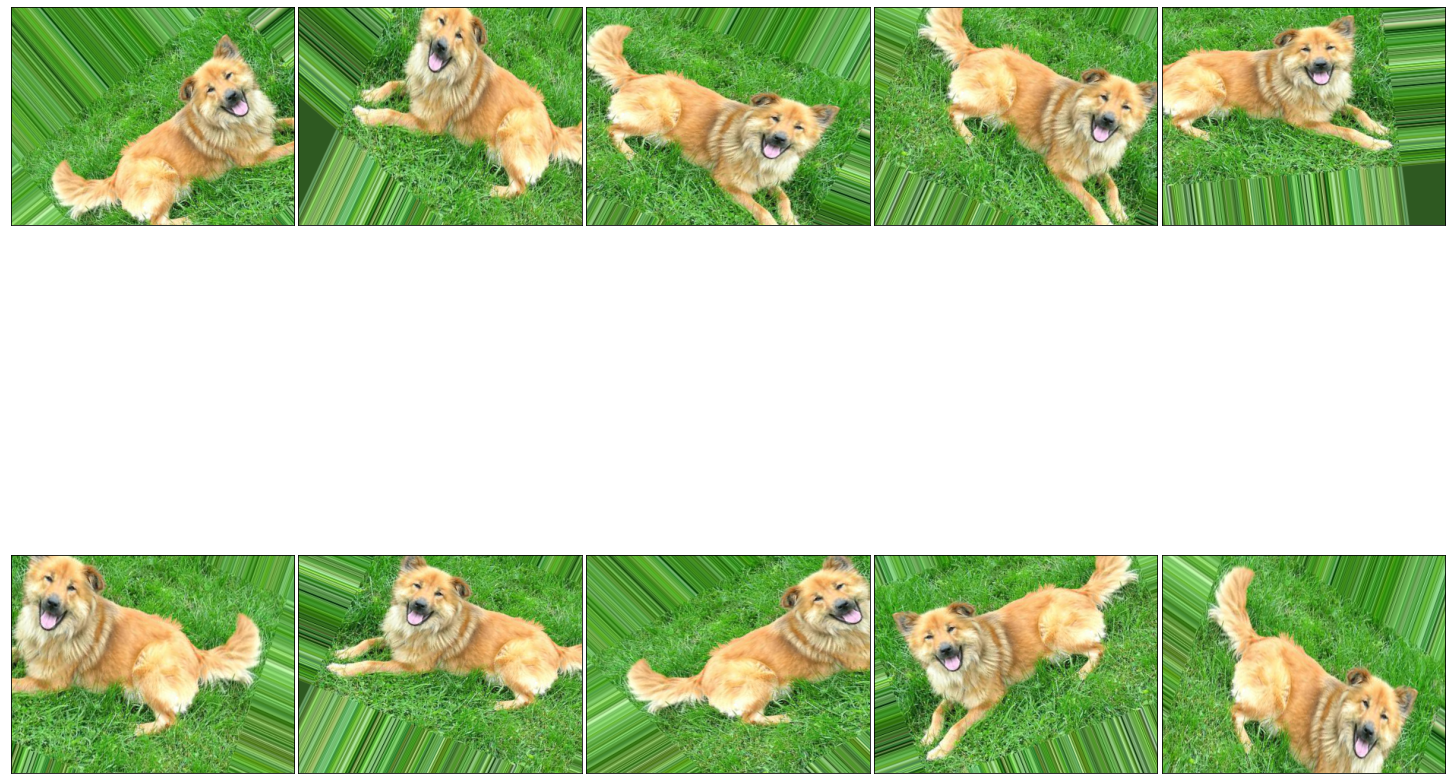

In [ ]:
fig , ax = plt.subplots(nrows=2, ncols= 5, figsize = (20, 20), sharex=True, sharey=True)
ax = ax.flatten()
i=0
for batch in datagen.flow(img, batch_size=10):
    for imgs in batch:
      ax[i].imshow(imgs)
      i += 1
    if i > 9:
        break

ax[0].set_yticks([])
ax[0].set_xticks([])
plt.tight_layout(0.1)
plt.grid(False)

# Unbalancing Data , بخش ۳

In [ ]:
#Loading Data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
#Convering Type
train_images = X_train.astype('float32')
test_images = X_test.astype('float32')

# Standardizing
train_images = train_images / 255
test_images = test_images / 255

# One hot encoding the target class
num_classes = 10
train_labels = np_utils.to_categorical(y_train, num_classes)
test_labels = np_utils.to_categorical(y_test, num_classes)

In [3]:
# setting up augmentor
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

In [ ]:

#deletiing 4500 cat and dog sample
num_classes = 10
cat_index = np.where(y_train==3)[0]
dog_index = np.where(y_train==5)[0]
cat_index_delete = np.random.choice(cat_index, size = 4500, replace=False)
dog_index_delete = np.random.choice(dog_index, size = 4500, replace = False)
train_images_new = np.delete(train_images, [cat_index_delete, dog_index_delete], axis=0)
y_train_new = np.delete(y_train, [cat_index_delete, dog_index_delete], axis=0)
train_labels_new  = np_utils.to_categorical(y_train_new, num_classes)

In [ ]:
#creating model
weight_decay = 1e-4
model2 = Sequential()
model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(32, 32, 3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))

 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu')) 
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.3))

 
model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.4))

 
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(layers.Dense(num_classes, activation='softmax'))
 
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                      

In [ ]:
 #Setting optmizer
optimizer = tensorflow.keras.optimizers.Adam()

#compiling the model
model2.compile(optimizer= optimizer,
            loss='categorical_crossentropy', metrics=['acc'])

history = model2.fit(train_images_new, train_labels_new, batch_size=64, epochs=40,
                    validation_data=(test_images, test_labels))

Epoch 1/40
641/641 [==============================] - 20s 27ms/step - loss: 1.7786 - acc: 0.4093 - val_loss: 1.7106 - val_acc: 0.4664
Epoch 2/40
641/641 [==============================] - 17s 26ms/step - loss: 1.1970 - acc: 0.5975 - val_loss: 1.4942 - val_acc: 0.5417
Epoch 3/40
641/641 [==============================] - 17s 26ms/step - loss: 0.9857 - acc: 0.6831 - val_loss: 1.4922 - val_acc: 0.5494
Epoch 4/40
641/641 [==============================] - 17s 26ms/step - loss: 0.8721 - acc: 0.7324 - val_loss: 1.1595 - val_acc: 0.6220
Epoch 5/40
641/641 [==============================] - 18s 28ms/step - loss: 0.7932 - acc: 0.7603 - val_loss: 1.0873 - val_acc: 0.6493
Epoch 6/40
641/641 [==============================] - 17s 27ms/step - loss: 0.7392 - acc: 0.7812 - val_loss: 1.0677 - val_acc: 0.6694
Epoch 7/40
641/641 [==============================] - 17s 26ms/step - loss: 0.6983 - acc: 0.8021 - val_loss: 0.9864 - val_acc: 0.6920
Epoch 8/40
641/641 [==============================] - 17s 26ms

## Confusion Matrix

In [ ]:
label_pred = model2.predict(test_images)
# Convert predictions classes to one hot vectors 
label_pred_classes = np.argmax(label_pred,axis = 1) 
# Convert validation observations to one hot vectors
label_true = np.argmax(test_labels,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(label_true, label_pred_classes)

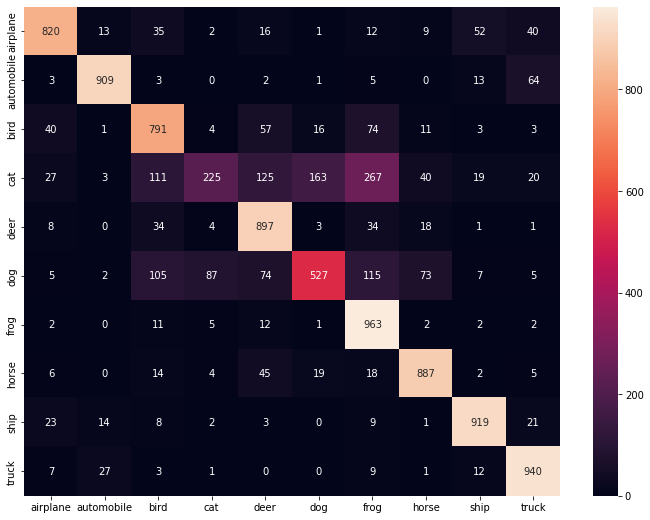

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g');
c.set(xticklabels=class_names, yticklabels=class_names);

# بخش ۴

In [ ]:
 cat_index = np.where(y_train_new==3)[0]
dog_index = np.where(y_train_new==5)[0]
i=0
temp = np.zeros((4500,32, 32, 3))
for batch in datagen.flow(train_images_new[cat_index], batch_size=4500):
    for imgs in batch:
      immg = imgs.reshape((1,) + imgs.shape)
      temp[i] = immg
      y_train_new = np.append(y_train_new,[[3]], axis=0)
      i += 1
    if i > 4499:
        break
train_images_new = np.append(train_images_new, temp, axis=0)
temp2 = np.zeros((4500,32, 32, 3))
i=0
for batch in datagen.flow(train_images_new[dog_index], batch_size=4500):
    for imgs in batch:
      immg = imgs.reshape((1,) + imgs.shape)
      temp2[i] = immg
      y_train_new =  np.append(y_train_new,[[5]],axis=0)
      i += 1
    if i > 4499:
        break
train_images_new = np.append(train_images_new, temp2, axis=0)
train_labels_new  = np_utils.to_categorical(y_train_new, num_classes)

In [ ]:
weight_decay = 1e-4
model2 = Sequential()
model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(32, 32, 3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))

 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu')) 
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.3))

 
model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.4))

 
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(layers.Dense(num_classes, activation='softmax'))
 
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_12 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_13 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_17 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                     

In [ ]:
 #Setting optmizer
optimizer = tensorflow.keras.optimizers.Adam()

#compiling the model
model2.compile(optimizer= optimizer,
            loss='categorical_crossentropy', metrics=['acc'])

history = model2.fit(train_images_new, train_labels_new, batch_size=64, epochs=40,
                    validation_data=(test_images, test_labels))

Epoch 1/40
782/782 [==============================] - 31s 35ms/step - loss: 1.7511 - acc: 0.3964 - val_loss: 1.4050 - val_acc: 0.5089
Epoch 2/40
782/782 [==============================] - 22s 28ms/step - loss: 1.1821 - acc: 0.5871 - val_loss: 1.3769 - val_acc: 0.5578
Epoch 3/40
782/782 [==============================] - 24s 30ms/step - loss: 0.9973 - acc: 0.6640 - val_loss: 1.0742 - val_acc: 0.6445
Epoch 4/40
782/782 [==============================] - 24s 31ms/step - loss: 0.8880 - acc: 0.7109 - val_loss: 1.1193 - val_acc: 0.6468
Epoch 5/40
782/782 [==============================] - 23s 29ms/step - loss: 0.8126 - acc: 0.7434 - val_loss: 0.9264 - val_acc: 0.7218
Epoch 6/40
782/782 [==============================] - 24s 30ms/step - loss: 0.7620 - acc: 0.7652 - val_loss: 0.8537 - val_acc: 0.7454
Epoch 7/40
782/782 [==============================] - 27s 35ms/step - loss: 0.7224 - acc: 0.7869 - val_loss: 1.1338 - val_acc: 0.6929
Epoch 8/40
782/782 [==============================] - 20s 26ms

## Confusion matrix

In [ ]:
label_pred = model2.predict(test_images)
# Convert predictions classes to one hot vectors 
label_pred_classes = np.argmax(label_pred,axis = 1) 
# Convert validation observations to one hot vectors
label_true = np.argmax(test_labels,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(label_true, label_pred_classes)

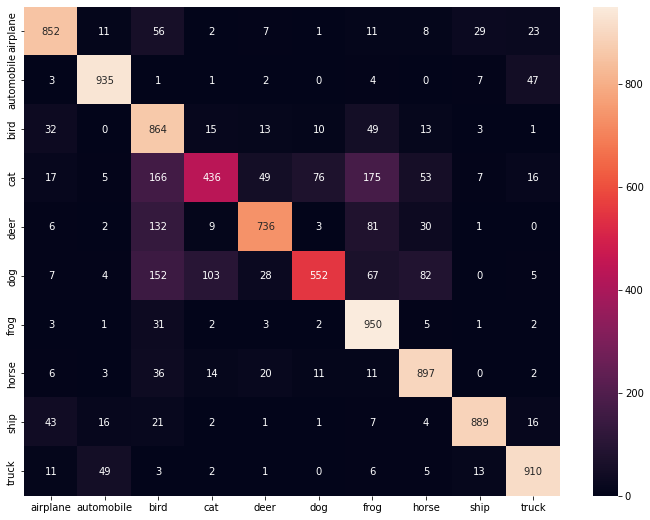

In [ ]:
plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g');
c.set(xticklabels=class_names, yticklabels=class_names);

## Results

We can see that after unbalancing data classes of dog and cats the model cant predict thsese two classes correctly specially for the cat class where model classifies most of them as frogs !!!!, but after data augmentation we can see model performance improves significantly on these two class and majority of predictions of model. on test data are corret(more than 50 percent), but imporovements are not very outstanding because oversampling hasn't happened with new pictures and only current 500 pictures of each class have been augmented so the model clearly cannot learn feature maps of these two classes as well as other majority classes and therefore results are not equal in term of correct predictions with majority classes even after data augmentation!